In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
import pymannkendall as mk

In [2]:
well_data = pd.read_excel('../data/Data-Wells.xlsx')
rm_nd = well_data.loc[well_data['1,4-Dioxane Results (ppb)'] != 'nd'].copy()
rm_capital_nd = rm_nd.loc[rm_nd['1,4-Dioxane Results (ppb)'] != 'ND'].copy()
rm_capital_nd['1,4-Dioxane Results (ppb)'] = rm_capital_nd['1,4-Dioxane Results (ppb)'].map(lambda x: x.replace(',', ''))
rm_capital_nd['1,4-Dioxane Results (ppb)'] = rm_capital_nd['1,4-Dioxane Results (ppb)'].map(lambda x: x.replace('<', ''))
res = rm_capital_nd
res.loc[:, 'ds']= pd.to_datetime(res['Date Sampled'])
res.loc[:, 'dioxane_results']= pd.to_numeric(res['1,4-Dioxane Results (ppb)'])
di_time = res.iloc[:, lambda df: df.columns.str.contains('Well Name|ds|dioxane_results',
                                              case=False)].copy()
di_time.rename(columns = {'dioxane_results':'y'}, inplace = True)
di_time.head(20)

,Well Name,ds,y
16,110 Parkland Plaza,1986-08-22,17.0
17,110 Parkland Plaza,1986-09-19,17.0
18,110 Parkland Plaza,1986-10-10,12.0
19,110 Parkland Plaza,1986-10-10,1.0
20,110 Parkland Plaza,1987-11-09,7.0
21,110 Parkland Plaza,1987-11-09,18.0
22,110 Parkland Plaza,1988-04-18,13.0
23,110 Parkland Plaza,1988-12-09,14.0
24,110 Parkland Plaza,1989-07-19,11.0
25,110 Parkland Plaza,1990-01-30,12.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

Initiated AutoTS object with best model: 
LastValueNaive
{"fillna": "ffill_mean_biased", "transformations": {"0": "ClipOutliers", "1": "MinMaxScaler"}, "transformation_params": {"0": {"method": "clip", "std_threshold": 3, "fillna": null}, "1": {}}}
{}
               y
2020-12-31  73.0
2021-12-31  73.0
2022-12-31  73.0
2023-12-31  73.0
2024-12-31  73.0
----------------
<class 'pandas.core.frame.DataFrame'>
                                   ID               Model  \
0    035ded2dfa23eb5b247e95d2e3e68176            Ensemble   
1    03d7037a163b1c2f00374604ba736950                 ETS   
2    048f2309efa854c00346c76e5a70dd9e   AverageValueNaive   
3    06d284117822f5632231d40c692d2bc7    WindowRegression   
4    08193b8ef7be1a88a20b3c5ddc0aaef1       SeasonalNaive   
..                                ...                 ...   
201  fa4e0d6ed60e8efcbfd4cc422ed3a5c9                 GLS   
202  fb1e2514f899e403c1a0fed546e7ec31         ZeroesNaive   
203  fd97c85f54ecb87fbeda381d0209c28c     

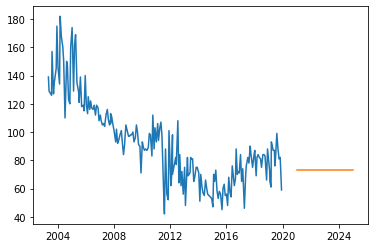

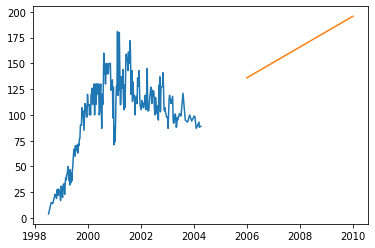

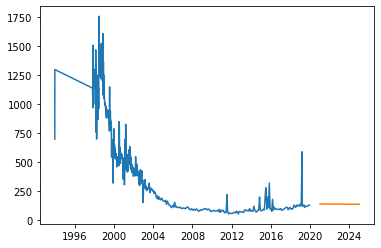

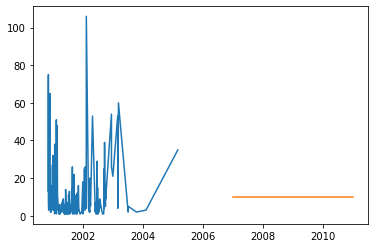

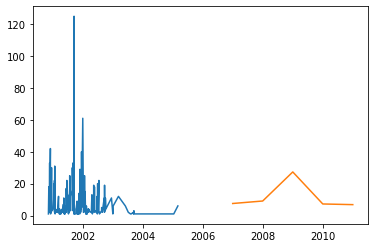

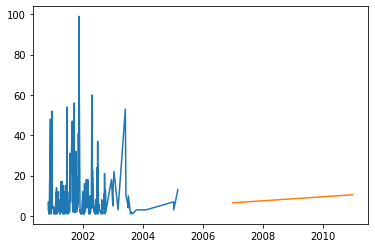

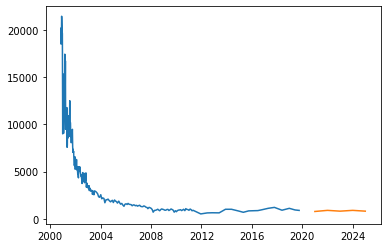

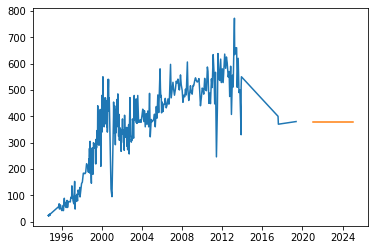

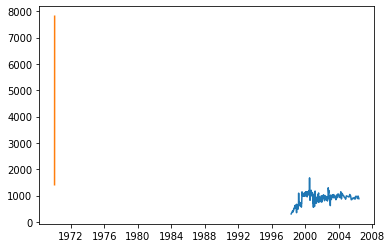

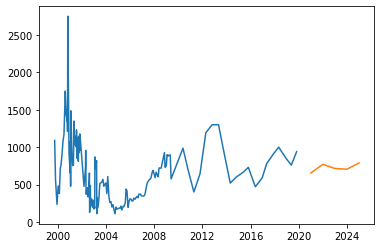

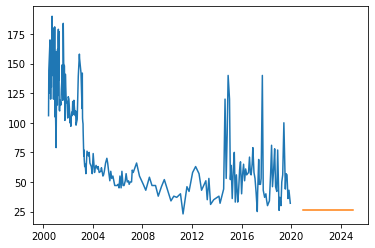

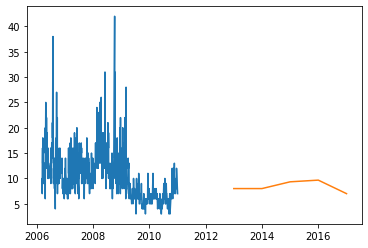

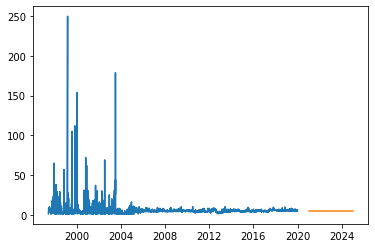

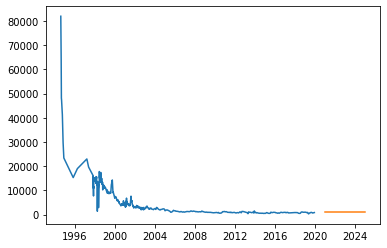

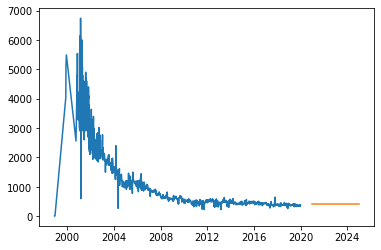

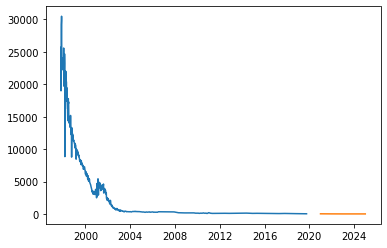

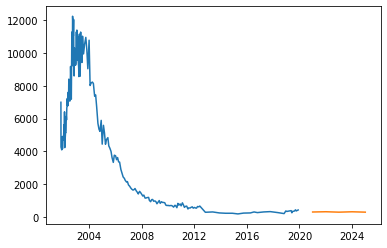

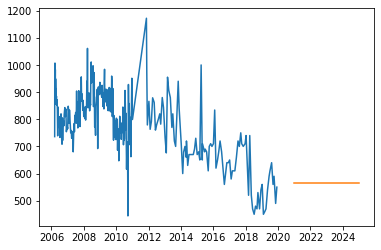

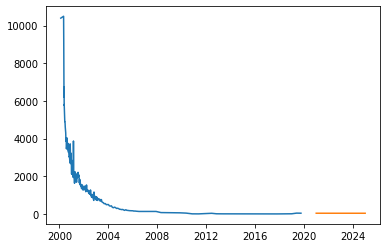

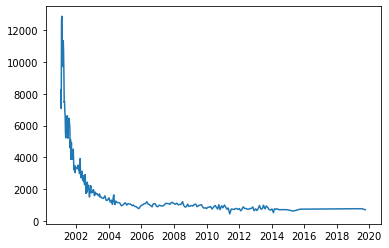

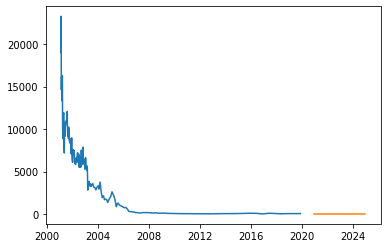

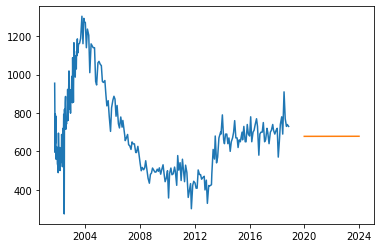

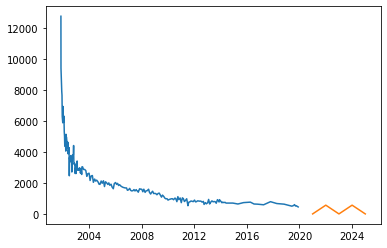

In [4]:
from autots import AutoTS
IS_DEBUG = False
grouped = di_time.groupby('Well Name')
n_rows = 1
count = 0
for name, group in grouped:
    # if count >= n_rows:
    #     break
    if len(group) < 200:
        continue

    group['Date'] = pd.to_datetime(group['ds'])
    group.set_index('Date', inplace=True)
    mod = AutoTS(forecast_length=5, frequency='Y',  ensemble='simple', no_negatives=True,
                 min_allowed_train_percent = 0.2,
                 verbose=-4)
    mod = mod.fit(group, date_col='ds', value_col='y', id_col=None)
    print(mod)
    prediction = mod.predict()
    forecast = prediction.forecast
    model_results = mod.results()
    validation = mod.results("validation")
    #Forecast
    print(forecast)
    print("----------------")
    print(type(forecast))
    plt.plot(group.y,  label='a')
    plt.plot(forecast,  label='b')
    plt.show()
    #Validation Results
    print(validation)
    count+=1
